In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm

#Load CSV
df = pd.read_csv(
    r"C:\Users\thoma\Desktop\Masters Project\Raw Data\Raw Data Collection\Subject 1 - Run 1 - Sitting - 4 Minutes\adc_data.csv"
)

# Determine dimensions
n_frames   = df['Frame Index'].max() + 1
n_chirps   = df['Chirp Index'].max() + 1
n_samples  = df['Sample Index'].max() + 1
n_rx       = df['Antenna Index'].max() + 1
n_tx       = 2  # assumed 1 TX since no TX info in file

#Create empty complex array [RX, Samples, TX, Chirps, Frames]
data = np.zeros((n_rx, n_samples, n_tx, n_chirps, n_frames), dtype=np.complex64)

#Fill array with the I/Q values
for row in tqdm(df.itertuples(index=False), total=len(df), desc="Loading ADC data"):
    frame    = int(row[0])
    chirp    = int(row[1])
    sample   = int(row[2])
    antenna  = int(row[3])
    i_val    = row[4]
    q_val    = row[5]

    data[antenna, sample, 0, chirp, frame] = complex(i_val, q_val)

print(f"Loaded data shape: {data.shape}")


Loading ADC data: 100%|████████████████████████████████████████████████| 14745600/14745600 [00:27<00:00, 541940.38it/s]

Loaded data shape: (3, 256, 2, 64, 300)


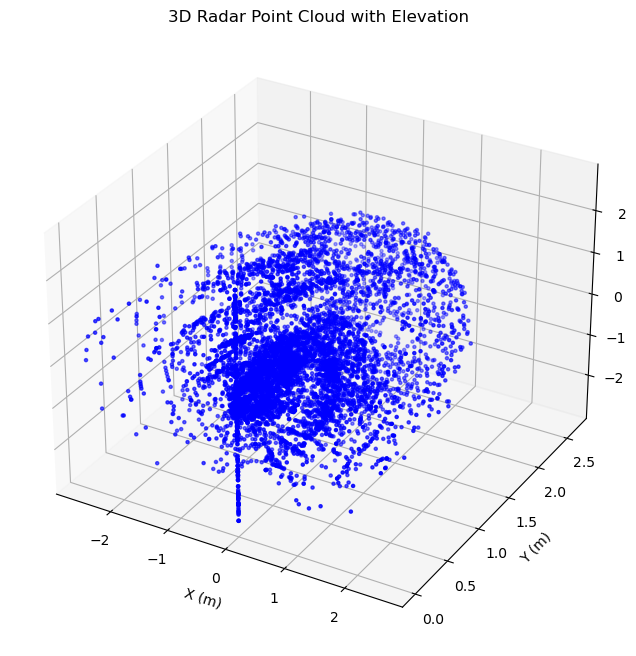

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Radar constants
c = 3e8
f_c = 60.5e9  #frequency in Hz
wavelength = c / f_c
range_resolution = 0.0214  #meters per bin
n_rx, n_samples, n_tx, n_chirps, n_frames = data.shape
n_angle_bins = 64  #resolution of FFT

#Output storage
points = []

#Process one frame and one transmitting antenna
frame = 0
tx = 0
frame_data = data[:, :, tx, :, frame]

#perform Range FFT
window = np.hanning(n_samples)
windowed_data = frame_data * window[:, np.newaxis]
range_fft = np.fft.fft(windowed_data, axis=1)
range_fft = range_fft[:, :n_samples // 2, :]

# Antenna index mapping based on your layout
# Rx1 = 0, Rx2 = 1, Rx3 = 2 --- Recieving antennas
for r in range(range_fft.shape[1]):  # range bins
    for d in range(range_fft.shape[2]):  # chirps
        signal = range_fft[:, r, d]

        if np.abs(signal).max() < 1e2:
            continue  # skip weak reflections

        rx1 = signal[0]  # horizontal
        rx2 = signal[1]  # reference
        rx3 = signal[2]  # vertical

        # --- Azimuth values from Rx2-Rx1 ---
        az_signal = np.array([rx2, rx1])
        az_fft = np.fft.fftshift(np.fft.fft(az_signal, n=n_angle_bins))
        az_mag = np.abs(az_fft)
        az_idx = np.argmax(az_mag)
        sin_theta = np.clip(np.linspace(-1, 1, n_angle_bins)[az_idx], -1, 1)
        theta = np.arcsin(sin_theta)

        # --- Elevation values from Rx2-Rx3 ---
        el_signal = np.array([rx2, rx3])
        el_fft = np.fft.fftshift(np.fft.fft(el_signal, n=n_angle_bins))
        el_mag = np.abs(el_fft)
        el_idx = np.argmax(el_mag)
        sin_phi = np.clip(np.linspace(-1, 1, n_angle_bins)[el_idx], -1, 1)
        phi = np.arcsin(sin_phi)

        # Convert to Cartesian coordinates
        rng = r * range_resolution
        x = rng * np.cos(phi) * np.sin(theta)
        y = rng * np.cos(phi) * np.cos(theta)
        z = rng * np.sin(phi)

        points.append([x, y, z])

# Convert to points and plot
points = np.array(points)
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(points[:, 0], points[:, 1], points[:, 2], c='blue', s=5)
ax.set_xlabel('X (m)')
ax.set_ylabel('Y (m)')
ax.set_zlabel('Z (m)')
ax.set_title('3D Radar Point Cloud with Elevation')
plt.show()


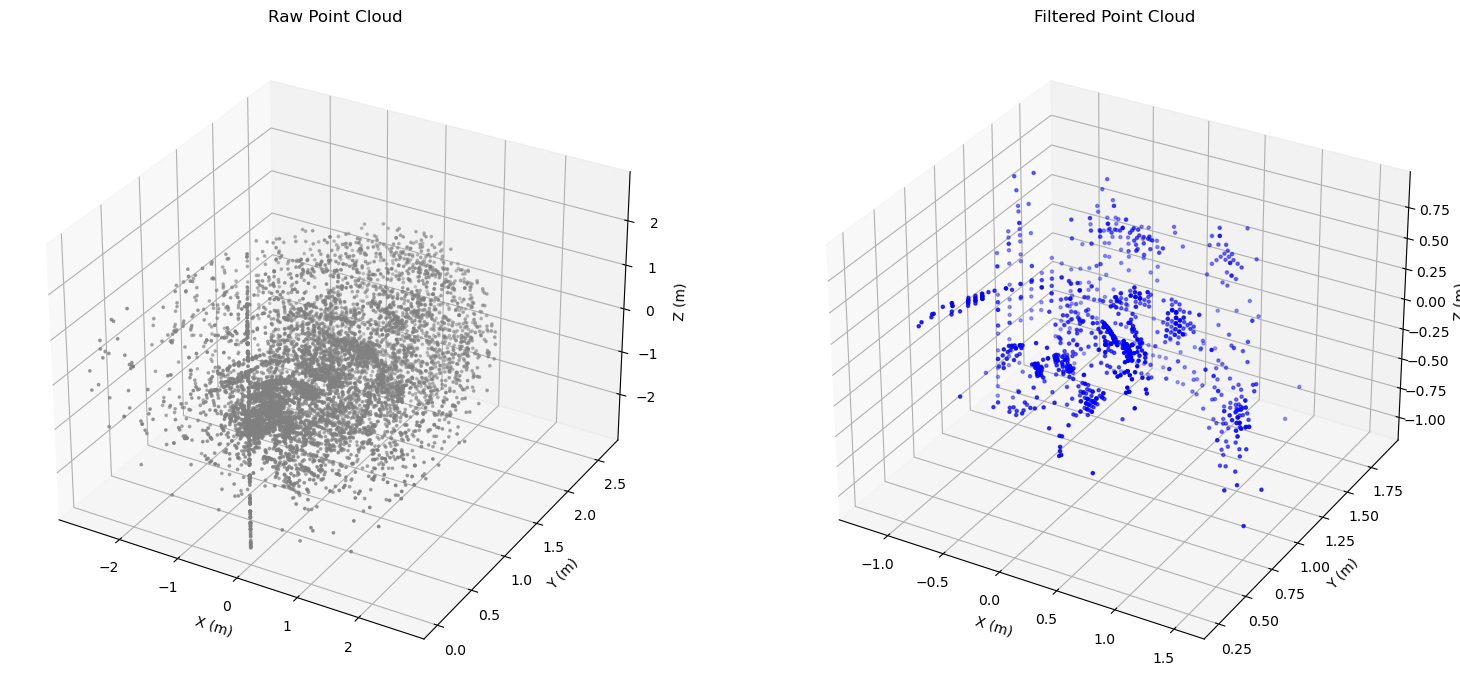

In [20]:
import numpy as np
import matplotlib.pyplot as plt

# Radar constants
c = 3e8
f_c = 60.5e9
wavelength = c / f_c
range_resolution = 0.0214
n_rx, n_samples, n_tx, n_chirps, n_frames = data.shape
n_angle_bins = 64

# Output storage
points_raw = []
points_filtered = []

# Use first TX, first frame
frame_data = data[:, :, 0, :, 100]

# Range FFT
window = np.hanning(n_samples)
windowed_data = frame_data * window[:, np.newaxis]
range_fft = np.fft.fft(windowed_data, axis=1)
range_fft = range_fft[:, :n_samples // 2, :]

# Angle grid
angle_grid = np.linspace(-1, 1, n_angle_bins)

for r in range(range_fft.shape[1]):
    for d in range(range_fft.shape[2]):
        signal = range_fft[:, r, d]

        if np.abs(signal).max() < 1e2:
            continue

        rx1, rx2, rx3 = signal[0], signal[1], signal[2]

        # Azimuth
        az_signal = np.array([rx2, rx1])
        az_fft = np.fft.fftshift(np.fft.fft(az_signal, n=n_angle_bins))
        az_mag = np.abs(az_fft)
        az_idx = np.argmax(az_mag)
        az_peak = az_mag[az_idx]
        sin_theta = np.clip(angle_grid[az_idx], -1, 1)
        theta = np.arcsin(sin_theta)

        # Elevation
        el_signal = np.array([rx2, rx3])
        el_fft = np.fft.fftshift(np.fft.fft(el_signal, n=n_angle_bins))
        el_mag = np.abs(el_fft)
        el_idx = np.argmax(el_mag)
        el_peak = el_mag[el_idx]
        sin_phi = np.clip(angle_grid[el_idx], -1, 1)
        phi = np.arcsin(sin_phi)

        rng = r * range_resolution
        x = rng * np.cos(phi) * np.sin(theta)
        y = rng * np.cos(phi) * np.cos(theta)
        z = rng * np.sin(phi)

        #append raw points
        points_raw.append([x, y, z])

        #applying thresholding
        if az_peak < 25000 or el_peak < 25000:
            continue
        if rng < 0.5 or rng > 10:
            continue
        if abs(theta) > np.radians(70) or abs(phi) > np.radians(30):
            continue

        #Append filtered points 
        points_filtered.append([x, y, z])

points_raw = np.array(points_raw)
points_filtered = np.array(points_filtered)

# Plot:raw vs filtered point clouds
fig = plt.figure(figsize=(16, 7))

#Raw point cloud
ax1 = fig.add_subplot(121, projection='3d')
ax1.scatter(points_raw[:, 0], points_raw[:, 1], points_raw[:, 2], c='gray', s=3)
ax1.set_title("Raw Point Cloud")
ax1.set_xlabel("X (m)")
ax1.set_ylabel("Y (m)")
ax1.set_zlabel("Z (m)")

#Filtered point cloud
ax2 = fig.add_subplot(122, projection='3d')
ax2.scatter(points_filtered[:, 0], points_filtered[:, 1], points_filtered[:, 2], c='blue', s=5)
ax2.set_title("Filtered Point Cloud")
ax2.set_xlabel("X (m)")
ax2.set_ylabel("Y (m)")
ax2.set_zlabel("Z (m)")

plt.tight_layout()
plt.show()


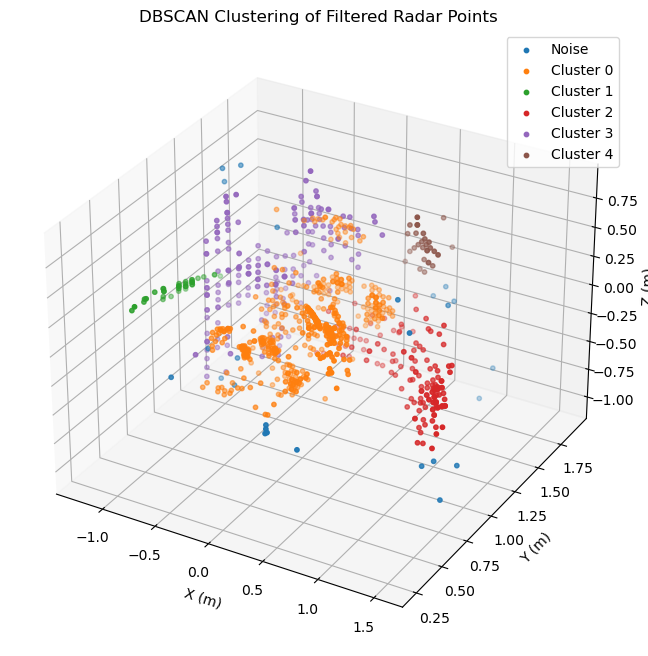

In [25]:
from sklearn.cluster import DBSCAN

##Clustering

#Parameters to tune
eps = 0.3  # meters: neighborhood size
min_samples = 20  # minimum no of points to form a cluster

# Apply DBSCAN on filtered point cloud
if len(points_filtered) > 0:
    clustering = DBSCAN(eps=eps, min_samples=min_samples).fit(points_filtered)
    labels = clustering.labels_  # -1 = noise, otherwise cluster ID
else:
    labels = []

#Plot clusters
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

if len(points_filtered) > 0:
    unique_labels = np.unique(labels)
    for label in unique_labels:
        cluster_points = points_filtered[labels == label]
        color = 'k' if label == -1 else None  # noise = black
        ax.scatter(cluster_points[:, 0], cluster_points[:, 1], cluster_points[:, 2],
                   label=f"Cluster {label}" if label != -1 else "Noise",
                   s=10)
    ax.legend()
    ax.set_title("DBSCAN Clustering of Filtered Radar Points")
else:
    ax.set_title("No Valid Points to Cluster")

ax.set_xlabel("X (m)")
ax.set_ylabel("Y (m)")
ax.set_zlabel("Z (m)")
plt.show()


<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

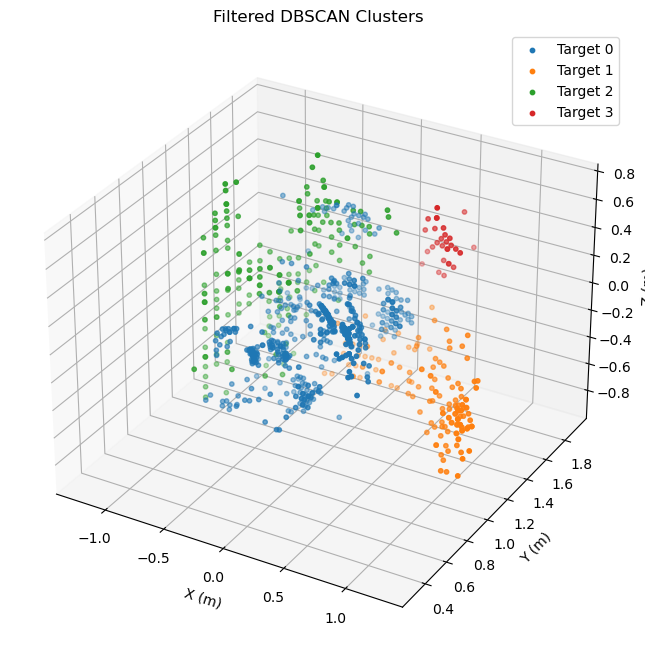

In [26]:
filtered_clusters = []
for label in np.unique(labels):
    if label == -1:
        continue  # skip noise
    cluster_points = points_filtered[labels == label]
    if len(cluster_points) < 10:  # discard small clusters
        continue
    spread = np.std(cluster_points, axis=0)
    if np.any(spread < 0.05):  # tiny spread, likely noise
        continue
    filtered_clusters.append(cluster_points)

    fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
for i, cluster in enumerate(filtered_clusters):
    ax.scatter(cluster[:, 0], cluster[:, 1], cluster[:, 2], label=f"Target {i}", s=10)
ax.set_title("Filtered DBSCAN Clusters")
ax.set_xlabel("X (m)")
ax.set_ylabel("Y (m)")
ax.set_zlabel("Z (m)")
ax.legend()
plt.show()


C:\Users\thoma\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


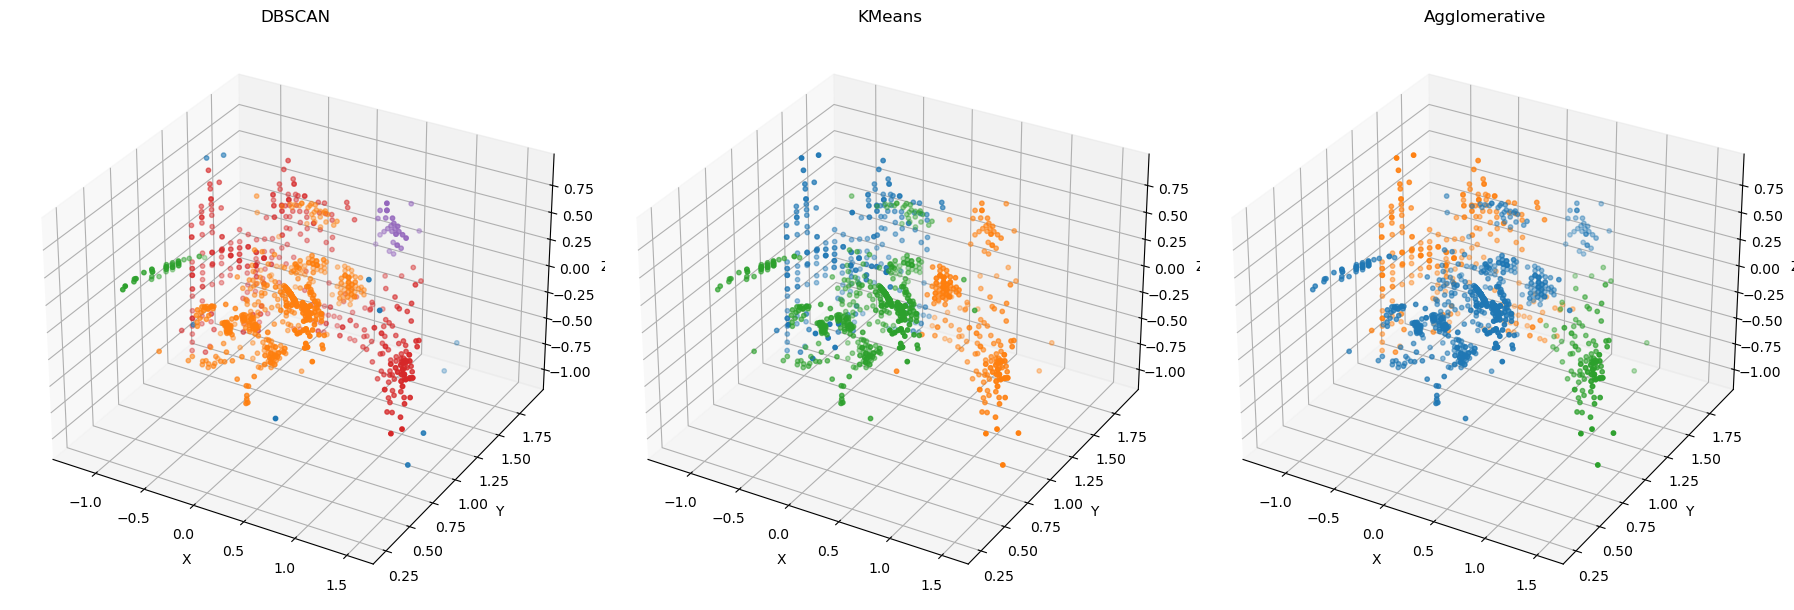

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN, KMeans, AgglomerativeClustering

points = np.array(points_filtered)

#skip if empty
if len(points) == 0:
    print("No points to cluster.")
else:
    # --- Clustering Config ---
    n_clusters = 3 #target no of targets, noise, person, other
    dbscan_eps = 0.3
    dbscan_min_samples = 10

    # --- Run DBSCAN ---
    db = DBSCAN(eps=dbscan_eps, min_samples=dbscan_min_samples).fit(points)
    db_labels = db.labels_

    # --- Run KMeans ---
    km = KMeans(n_clusters=n_clusters, n_init=10, random_state=42).fit(points)
    km_labels = km.labels_

    # --- Run Agglomerative ---
    agg = AgglomerativeClustering(n_clusters=n_clusters).fit(points)
    agg_labels = agg.labels_

    # --- Plot Side-by-Side ---
    fig = plt.figure(figsize=(18, 6))

    # DBSCAN
    ax1 = fig.add_subplot(131, projection='3d')
    for label in np.unique(db_labels):
        cluster = points[db_labels == label]
        color = 'gray' if label == -1 else None
        ax1.scatter(cluster[:, 0], cluster[:, 1], cluster[:, 2], label=f"Cluster {label}", s=10)
    ax1.set_title("DBSCAN")
    ax1.set_xlabel("X")
    ax1.set_ylabel("Y")
    ax1.set_zlabel("Z")

    # KMeans
    ax2 = fig.add_subplot(132, projection='3d')
    for label in np.unique(km_labels):
        cluster = points[km_labels == label]
        ax2.scatter(cluster[:, 0], cluster[:, 1], cluster[:, 2], label=f"Cluster {label}", s=10)
    ax2.set_title("KMeans")
    ax2.set_xlabel("X")
    ax2.set_ylabel("Y")
    ax2.set_zlabel("Z")

    # Agglomerative
    ax3 = fig.add_subplot(133, projection='3d')
    for label in np.unique(agg_labels):
        cluster = points[agg_labels == label]
        ax3.scatter(cluster[:, 0], cluster[:, 1], cluster[:, 2], label=f"Cluster {label}", s=10)
    ax3.set_title("Agglomerative")
    ax3.set_xlabel("X")
    ax3.set_ylabel("Y")
    ax3.set_zlabel("Z")

    plt.tight_layout()
    plt.show()


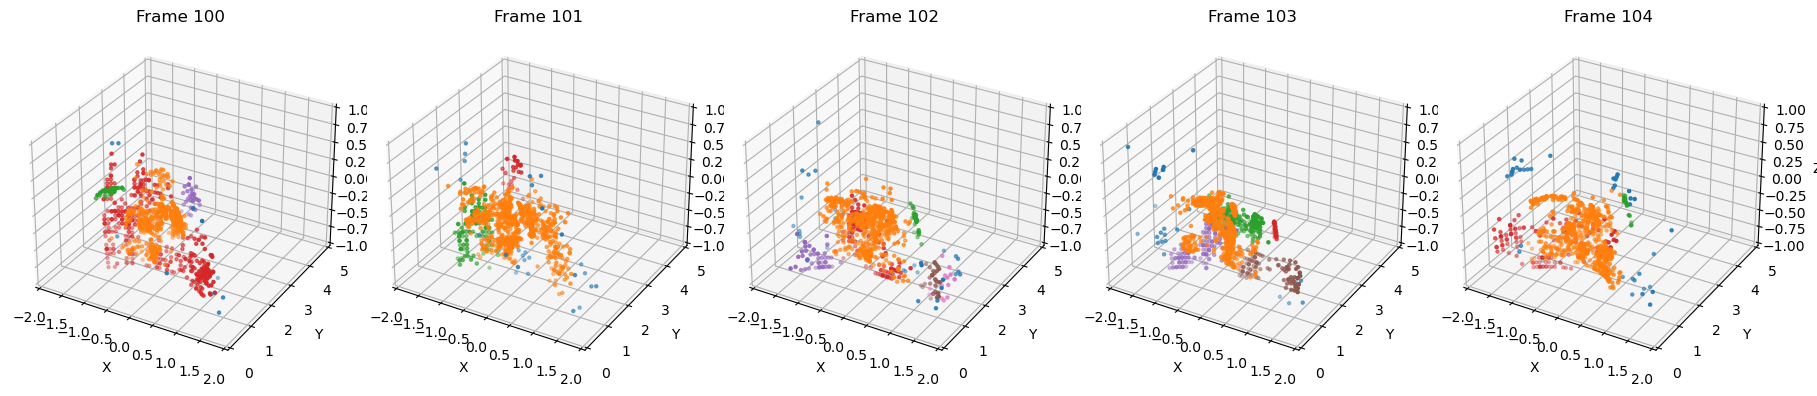

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN

#Plotting 5 clustered consecutive frames to examine consistency

start_frame = 100        
n_frames_to_plot = 5
dbscan_eps = 0.3
dbscan_min_samples = 10
n_angle_bins = 64

c = 3e8
f_c = 60.5e9
wavelength = c / f_c
range_resolution = 0.0214
window = np.hanning(data.shape[1])
angle_grid = np.linspace(-1, 1, n_angle_bins)

# Check frame bounds
end_frame = start_frame + n_frames_to_plot
if end_frame > data.shape[4]:
    raise ValueError(f"Requested frames exceed total available frames: {data.shape[4]}")

# Create subplot
fig = plt.figure(figsize=(18, 4))

for idx, frame_idx in enumerate(range(start_frame, end_frame)):
    points_filtered = []

    frame_data = data[:, :, 0, :, frame_idx]  # 1 TX only

    # Range FFT
    windowed_data = frame_data * window[:, np.newaxis]
    range_fft = np.fft.fft(windowed_data, axis=1)
    range_fft = range_fft[:, :data.shape[1] // 2, :]

    for r in range(range_fft.shape[1]):
        for d in range(range_fft.shape[2]):
            signal = range_fft[:, r, d]
            if np.abs(signal).max() < 1e2:
                continue

            rx1, rx2, rx3 = signal[0], signal[1], signal[2]

            # Azimuth
            az_signal = np.array([rx2, rx1])
            az_fft = np.fft.fftshift(np.fft.fft(az_signal, n=n_angle_bins))
            az_mag = np.abs(az_fft)
            az_idx = np.argmax(az_mag)
            az_peak = az_mag[az_idx]
            sin_theta = np.clip(angle_grid[az_idx], -1, 1)
            theta = np.arcsin(sin_theta)

            # Elevation
            el_signal = np.array([rx2, rx3])
            el_fft = np.fft.fftshift(np.fft.fft(el_signal, n=n_angle_bins))
            el_mag = np.abs(el_fft)
            el_idx = np.argmax(el_mag)
            el_peak = el_mag[el_idx]
            sin_phi = np.clip(angle_grid[el_idx], -1, 1)
            phi = np.arcsin(sin_phi)

            rng = r * range_resolution

            # Filtering
            if az_peak < 25000 or el_peak < 25000:
                continue
            if rng < 0.5 or rng > 10:
                continue
            if abs(theta) > np.radians(70) or abs(phi) > np.radians(30):
                continue

            x = rng * np.cos(phi) * np.sin(theta)
            y = rng * np.cos(phi) * np.cos(theta)
            z = rng * np.sin(phi)

            points_filtered.append([x, y, z])

    points_filtered = np.array(points_filtered)

    # Plot
    ax = fig.add_subplot(1, n_frames_to_plot, idx + 1, projection='3d')
    ax.set_title(f"Frame {frame_idx}")

    if len(points_filtered) > 0:
        db = DBSCAN(eps=dbscan_eps, min_samples=dbscan_min_samples).fit(points_filtered)
        labels = db.labels_
        for label in np.unique(labels):
            cluster = points_filtered[labels == label]
            color = 'k' if label == -1 else None
            ax.scatter(cluster[:, 0], cluster[:, 1], cluster[:, 2], s=5, label=f"Cl {label}" if label != -1 else "Noise")
    else:
        ax.text(0, 0, 0, "No points")

    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    ax.set_xlim([-2, 2])
    ax.set_ylim([0, 5])
    ax.set_zlim([-1, 1])

plt.tight_layout()
plt.show()


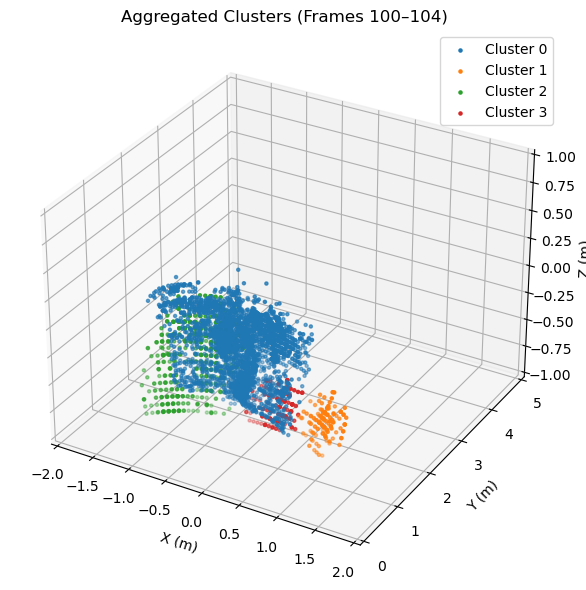

In [36]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN

# --- Config ---
start_frame = 100
n_frames_to_aggregate = 5
dbscan_eps = 0.2
dbscan_min_samples = 50
n_angle_bins = 64

# Radar constants
c = 3e8
f_c = 60.5e9
wavelength = c / f_c
range_resolution = 0.0214
window = np.hanning(data.shape[1])
angle_grid = np.linspace(-1, 1, n_angle_bins)

# --- Aggregate Points Across Frames ---
points_all = []

for frame_idx in range(start_frame, start_frame + n_frames_to_aggregate):
    if frame_idx >= data.shape[4]:
        break  # avoid going out of bounds

    # First TX channel
    frame_data = data[:, :, 0, :, frame_idx]

    # Range FFT
    windowed_data = frame_data * window[:, np.newaxis]
    range_fft = np.fft.fft(windowed_data, axis=1)
    range_fft = range_fft[:, :data.shape[1] // 2, :]

    for r in range(range_fft.shape[1]):
        for d in range(range_fft.shape[2]):
            signal = range_fft[:, r, d]

            if np.abs(signal).max() < 1e2:
                continue

            rx1, rx2, rx3 = signal[0], signal[1], signal[2]

            # Azimuth
            az_signal = np.array([rx2, rx1])
            az_fft = np.fft.fftshift(np.fft.fft(az_signal, n=n_angle_bins))
            az_mag = np.abs(az_fft)
            az_idx = np.argmax(az_mag)
            az_peak = az_mag[az_idx]
            sin_theta = np.clip(angle_grid[az_idx], -1, 1)
            theta = np.arcsin(sin_theta)

            # Elevation
            el_signal = np.array([rx2, rx3])
            el_fft = np.fft.fftshift(np.fft.fft(el_signal, n=n_angle_bins))
            el_mag = np.abs(el_fft)
            el_idx = np.argmax(el_mag)
            el_peak = el_mag[el_idx]
            sin_phi = np.clip(angle_grid[el_idx], -1, 1)
            phi = np.arcsin(sin_phi)

            rng = r * range_resolution

            # Filtering
            if az_peak < 25000 or el_peak < 25000:
                continue
            if rng < 0.5 or rng > 10:
                continue
            if abs(theta) > np.radians(70) or abs(phi) > np.radians(30):
                continue

            x = rng * np.cos(phi) * np.sin(theta)
            y = rng * np.cos(phi) * np.cos(theta)
            z = rng * np.sin(phi)

            points_all.append([x, y, z])

# Convert to NumPy array
points_all = np.array(points_all)

# --- Clustering ---
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.set_title(f"Aggregated Clusters (Frames {start_frame}–{start_frame + n_frames_to_aggregate - 1})")

if len(points_all) > 0:
    db = DBSCAN(eps=dbscan_eps, min_samples=dbscan_min_samples).fit(points_all)
    labels = db.labels_

    for label in np.unique(labels):
        if label == -1:
            continue  # skip DBSCAN noise
        cluster = points_all[labels == label]

        # Noise removal: drop tiny or flat clusters
        if len(cluster) < 10:
            continue
        spread = np.std(cluster, axis=0)
        if np.any(spread < 0.05):
            continue

        ax.scatter(cluster[:, 0], cluster[:, 1], cluster[:, 2], s=5, label=f"Cluster {label}")

    ax.legend()
else:
    ax.text(0, 0, 0, "No valid points found", fontsize=10)

# Axis settings
ax.set_xlabel("X (m)")
ax.set_ylabel("Y (m)")
ax.set_zlabel("Z (m)")
ax.set_xlim([-2, 2])
ax.set_ylim([0, 5])
ax.set_zlim([-1, 1])
plt.tight_layout()
plt.show()
